In [1]:
import scanpy as sc
import scvelo as scv

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def gene_trends(adata, gene, hue='clusters', pt_key='palantir_pseudotime', ukey='Mu', skey='Ms'):
    """
    plotting gene trends based on cellrank GAM regression model, if not, the raw data will be displayed.
    :param adata:
    :return:
    """
    for i in range(adata.shape[1]):
        if adata.var.index[i] == gene:
            break

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.scatterplot(x=adata.obs[pt_key],
                    y=np.array(adata.layers[ukey][:, i]).reshape(-1),
                    hue=adata.obs[hue], marker='.', edgecolor='none', ax=axes[0])
    axes[0].set_ylabel('unspliced')
    axes[0].set_xlabel(pt_key)
    axes[0].get_legend().remove()

    # Plot 3
    sns.scatterplot(x=adata.obs[pt_key],
                    y=np.array(adata.layers[skey][:, i]).reshape(-1),
                    hue=adata.obs[hue], marker='.', edgecolor='none', ax=axes[1])
    axes[1].set_ylabel('spliced')
    axes[1].set_xlabel(pt_key)
    axes[1].get_legend().remove()

    # Remove top and right spines
    for j in range(2):
        axes[j].spines['top'].set_visible(False)
        axes[j].spines['right'].set_visible(False)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(gene + ' gene expression')
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

    plt.show()


def phase_plot(adata, gene=None, hue='clusters', ukey='Mu', skey='Ms'):
    """
    plot gene expression phase plot. x-axis is spliced, y-axis is unspliced.

    :param adata:
    :return:
    """
    for i in range(adata.shape[1]):
        if adata.var.index[i] == gene:
            break

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.scatterplot(x=np.array(adata.layers[skey][:, i]).reshape(-1),
                    y=np.array(adata.layers[ukey][:, i]).reshape(-1),
                    hue=adata.obs[hue], marker='.', edgecolor='none', ax=ax)
    ax.set_ylabel('unspliced')
    ax.set_xlabel('spliced')
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)
    plt.show()

def kinetics_trends(adata, gene, hue='clusters', pt_key='palantir_pseudotime',
                    kinetics_key={'alpha':'alpha', 'beta':'beta', 'gamma':'gamma'}):
    """
    plotting kinetics trends based on cellrank GAM regression model, if not, the raw data will be displayed.
    :param adata:
    :return:
    """
    for i in range(adata.shape[1]):
        if adata.var.index[i] == gene:
            break

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))


    sns.scatterplot(x=adata.obs[pt_key],
                    y=np.array(adata.layers[kinetics_key['alpha']][:, i]).reshape(-1),
                    hue=adata.obs[hue], marker='.', edgecolor='none', ax=axes[0])
    axes[0].set_ylabel('alpha')
    axes[0].set_xlabel(pt_key)
    axes[0].get_legend().remove()

    # Plot 3
    sns.scatterplot(x=adata.obs[pt_key],
                    y=np.array(adata.layers[kinetics_key['beta']][:, i]).reshape(-1),
                    hue=adata.obs[hue], marker='.', edgecolor='none', ax=axes[1])
    axes[1].set_ylabel('beta')
    axes[1].set_xlabel(pt_key)
    axes[1].get_legend().remove()

    sns.scatterplot(x=adata.obs[pt_key],
                    y=np.array(adata.layers[kinetics_key['gamma']][:, i]).reshape(-1),
                    hue=adata.obs[hue], marker='.', edgecolor='none', ax=axes[2])
    axes[2].set_ylabel('gamma')
    axes[2].set_xlabel(pt_key)
    axes[2].get_legend().remove()

    # Remove top and right spines
    for j in range(3):
        axes[j].spines['top'].set_visible(False)
        axes[j].spines['right'].set_visible(False)
    handles, labels = axes[0].get_legend_handles_labels()
    
    fig.suptitle(gene + ' kinetics trends')
    fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

    plt.show()


def phase_plot_velocity(adata, gene=None, hue=None,
                        vkey={'unspliced_velocity': "unspliced_velocity",
                              'spliced_velocity': "spliced_velocity"},
                        ukey='Mu', skey='Ms',
                        arrow_length=1e-3,
                        width=.0015,
                        dpi=120,):
    """
    plot velocity in the phase plot.
    :param adata:
    :return:
    """
    for i in range(adata.shape[1]):
        if adata.var.index[i] == gene:
            break
    x = np.array(adata.layers[skey][:, i]).reshape(-1, 1)
    y = np.array(adata.layers[ukey][:, i]).reshape(-1, 1)

    print(i)

    x_v = np.array(adata.layers[vkey['spliced_velocity']][:, i]).reshape(-1, 1)
    y_v = np.array(adata.layers[vkey['unspliced_velocity']][:, i]).reshape(-1, 1)

    X = np.concatenate((x, y), axis=1)
    V = np.concatenate((x_v, y_v), axis=1)

    adata_new = sc.AnnData(X=X, obs=adata.obs)
    adata_new.layers['Ms'] = X
    adata_new.obsm['X_' + gene] = X
    adata_new.layers[gene + '_velocity'] = V

    scv.pl.velocity_embedding(adata_new, basis=gene, X=X, V=V, c=hue, vkey=gene + '_velocity',
                              width=width,arrow_length=arrow_length,
                              dpi=dpi)



In [4]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

def rna_velocity_ode(y, t, alpha, beta, gamma):
    u, s = y
    du_dt = alpha - beta * u
    ds_dt = beta * u - gamma * s
    return [du_dt, ds_dt]

def refine_kinetics(u, s, t, alpha_init, beta_init, gamma_init, num_iter=300):
    u = np.array(u, dtype=np.float32)
    s = np.array(s, dtype=np.float32)
    t = np.array(t, dtype=np.float32)

    def model_loss(log_params, u, s, t):
        alpha, beta, gamma = np.exp(log_params)
        y0 = [u[0], s[0]]  # Initial conditions
        sol = odeint(rna_velocity_ode, y0, t, args=(alpha, beta, gamma))
        u_pred, s_pred = sol[:, 0], sol[:, 1]
        loss = np.mean(np.abs(u - u_pred) + np.abs(s - s_pred))
        return loss

    # Initial guesses for alpha, beta, gamma
    initial_guess = [np.log(alpha_init), np.log(beta_init), np.log(gamma_init)]

    # Optimization
    result = minimize(lambda params: model_loss(params, u, s, t), initial_guess, method='L-BFGS-B', options={'maxiter': num_iter})

    alpha, beta, gamma = np.exp(result.x)
    return alpha, beta, gamma


def refine_group(adata, gene, group_key, group_value,
                 pt_key='palantir_pseudotime',  vkey=None,
                 num_iter=100):
    
    adata = adata[adata.obs[group_key] == group_value].copy()
    pseudo_time = adata.obs[pt_key].values
    sorted_indices = np.argsort(pseudo_time)
    adata = adata[sorted_indices,]

    for gene_posititon in range(adata.shape[1]):
        if adata.var.index[gene_posititon] == gene:
            break
    u = adata.layers['Mu'][:,gene_posititon]
    s = adata.layers['Ms'][:,gene_posititon]
    t = adata.obs[pt_key].values

    alpha = adata.layers['alpha'][0,gene_posititon]
    beta = adata.layers['beta'][0,gene_posititon]
    gamma = adata.layers['gamma'][0,gene_posititon]
    
    n_samples = adata.shape[0]

    alpha, beta, gamma = refine_kinetics(u, s, t, alpha, beta, gamma,
                                         num_iter=num_iter)

    alpha = np.repeat(alpha, n_samples, axis=0)
    beta = np.repeat(beta, n_samples, axis=0)
    gamma = np.repeat(gamma, n_samples, axis=0)
    
    adata.layers['alpha'][:,gene_posititon] = alpha
    adata.layers['beta'][:,gene_posititon] = beta
    adata.layers['gamma'][:,gene_posititon] = gamma
    
    adata.layers[vkey['spliced_velocity']] = adata.layers['Mu'] * adata.layers['beta'] - adata.layers['Ms'] * \
                                             adata.layers['gamma']
    adata.layers[vkey['unspliced_velocity']] = adata.layers['alpha'] - adata.layers['Mu'] * adata.layers['beta']
    return adata


def coarse_grained_refinement(adata, gene, group_key, pt_key='palantir_pseudotime',
                              vkey: dict = {'unspliced_velocity': "unspliced_velocity",
                                          'spliced_velocity': "spliced_velocity"},
                              num_iter=100, n_jobs=-1):
    
    """
    group-mode kinetics parameters inference. Assume each group of cells have the same kinetics parameters,
    and then solve the RNA velocity ODE with the neuralODE solver. All cells in the same group will have
    the same inferred kinetics parameters
    :param adata: anndata with necessary attributes like unspliced and spliced expression value saved in layers
    :param group_key: the key for the group, like "clusters", "cell_type", should be stored in adata.obs
    :param pt_key: pseudo-time key to retrieve the pseudo-time value, should be stored in adata.obs
    :param vkey: stored key of recalculated RNA velocity in adata.layers. Should specify the key for "unspliced_velocity"
    and "spliced_velocity" clearly.
    :param num_iter: number of iterations in the optimization steps
    :param n_jobs: number of cores for parallelization computation. -1 means use all cores.
    :return: adata stored with group-level kinetics information
    """
    import anndata
    from joblib import Parallel, delayed
    from tqdm import tqdm
    adata_obsp = adata.obsp.copy()
    adata_uns = adata.uns.copy()

    group_values = adata.obs[group_key].value_counts().index

    # Run the processing in parallel
    adata_list = Parallel(n_jobs=n_jobs, prefer="processes", backend='loky')(
        delayed(refine_group)(adata, gene, group_key, group_value, pt_key=pt_key, vkey=vkey, num_iter=num_iter) for group_value in
        tqdm(group_values))

    # Concatenate the results
    adata = anndata.concat(adata_list, axis=0)

    adata.obsp = adata_obsp
    adata.uns = adata_uns

    return adata

In [155]:
adata = sc.read('../data/gastrulation_murk_hires.h5ad')

In [156]:
# adata = coarse_grained_refinement(adata, gene='Hhex', group_key='clusters', pt_key='palantir_pseudotime', num_iter=1000)

14


AttributeError: can't set attribute

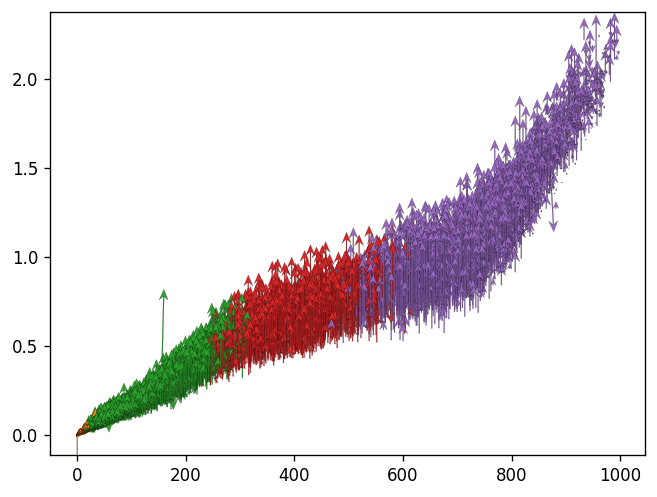

In [161]:
phase_plot_velocity(adata, "Hba-x", hue='celltype', arrow_length=5e-4)

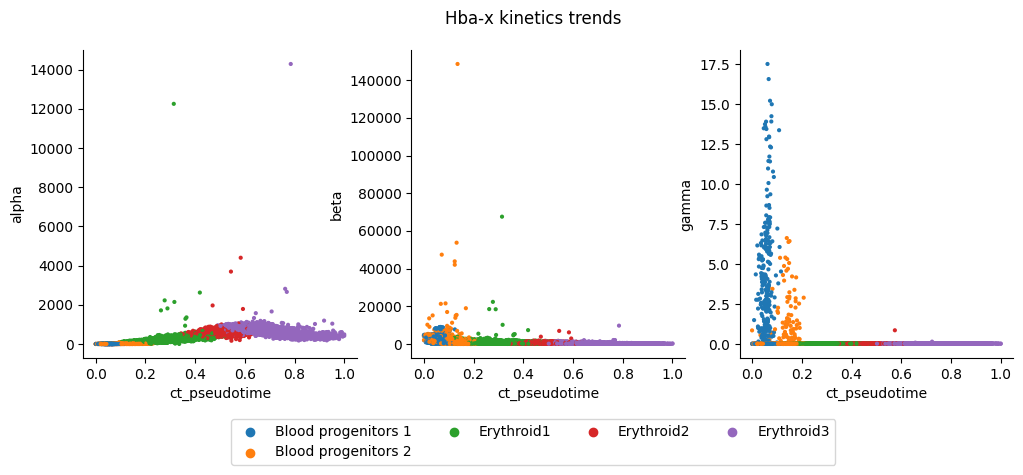

In [164]:
kinetics_trends(adata, 'Hba-x', hue='celltype', pt_key='ct_pseudotime',
                kinetics_key={'alpha':'alpha', 'beta':'beta', 'gamma':'gamma'})

In [103]:
# from scipy import stats
# MEG = []
# for i in range(adata.shape[1]):
#     gene_i = adata.X[:,i]
#     gene_i = np.array(gene_i.todense()).reshape(-1)
#     pt = adata.obs['palantir_pseudotime'].values
#     corr, pval = stats.pearsonr(gene_i, pt)
#     if corr >= 0.9:
#         MEG.append(i)

In [104]:
# MEG

In [141]:
adata.obsp = None
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)

computing velocity graph (using 8/8 cores)
    finished (0:00:15) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


AttributeError: can't set attribute

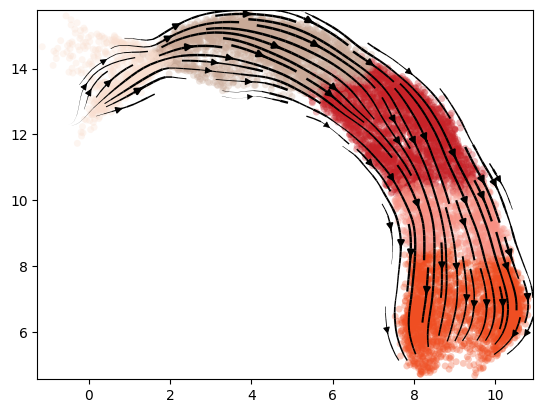

In [143]:
scv.tl.velocity_graph(adata, vkey='spliced_velocity',n_jobs=-1)
scv.pl.velocity_embedding_stream(adata, basis='umap', c='celltype',vkey='spliced_velocity')

AttributeError: can't set attribute

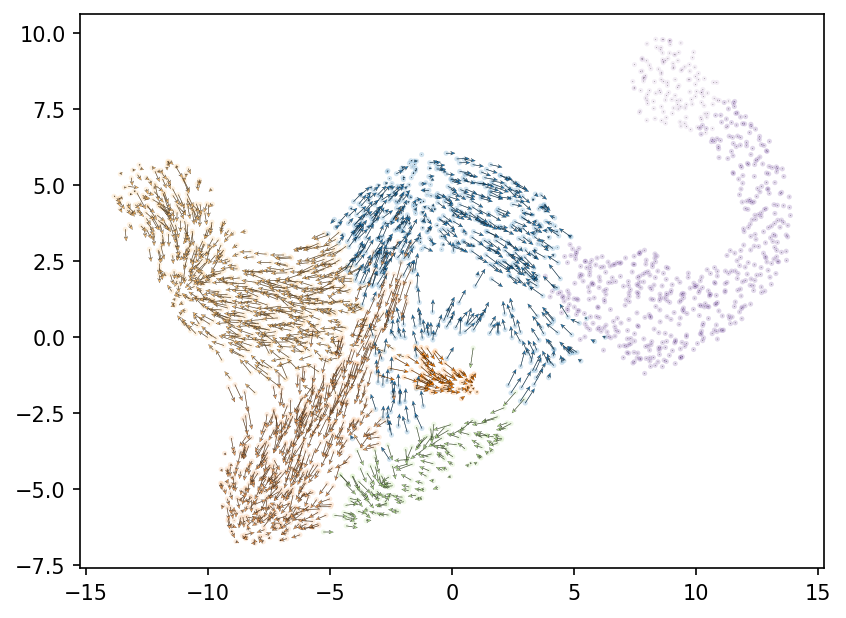

In [86]:
scv.pl.velocity_embedding(adata, basis='umap', c='clusters',vkey='unspliced_velocity', arrow_length=3, dpi=150)

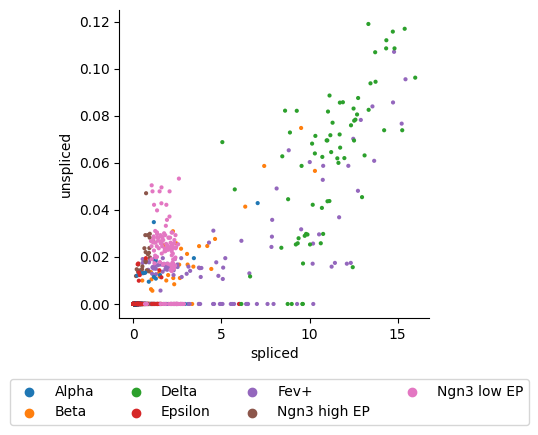

In [66]:
phase_plot(adata, "Hhex", hue='clusters')

In [149]:
adata[:,"Hba-x"]

View of AnnData object with n_obs × n_vars = 9815 × 1
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'ct_pseudotime'
    uns: 'celltype_colors', 'log1p', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'alpha', 'beta', 'gamma', 'spliced', 'spliced_velocity', 'unspliced', 'unspliced_velocity'
    obsp: 'connectivities', 'distances'